In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set(font_scale=1.2)
# Function `set` is deprecated in favor of `set_theme`
# https://seaborn.pydata.org/generated/seaborn.set_theme.html

print('Automobilių kainos vertinimas.\nTrečioji projekto versija.')

# Šis failas:
# /home/administratorius/git/python_kursai/DataScienceNotebooks/Studentai/MykolasOK/2024-11-13_autop.ipynb
# Duomenų šaltiniai:
# /home/administratorius/git/python_kursai/DataScienceNotebooks/DATA/atlyginimai.csv (-)
# /home/administratorius/git/python_kursai/DataScienceNotebooks/DATA/WEBscr.db (+)

print("Automobilių duomenys paimami iš DB failo")
conn = sqlite3.connect('../../DATA/WEBscr.db')
# query = "SELECT name FROM sqlite_master WHERE type='table';"
# print(pd.read_sql_query(query, conn)['name'].tolist())
query = '''SELECT TAutos.*, TUrl.url, TUrl.name, TUrl.params
            FROM TAutos
            LEFT JOIN TUrl ON TAutos.id = TUrl.id
            GROUP BY TAutos.id;'''
df=pd.read_sql_query(query, conn) # Kuriamas df.
# print(df.columns,end='\n')

print('Paimta įrašų:',len(df))

Automobilių kainos vertinimas.
Trečioji projekto versija.
Automobilių duomenys paimami iš DB failo
Paimta įrašų: 35913


In [10]:
# import pandas as pd
import re
from datetime import datetime

def extract_year(date_str):
    if not date_str:
        return None  # Grąžiname None, jei eilutė tuščia ar None

    # Reguliarioji išraiška, ieškanti metų ISO formato datos dalyje (YYYY-MM-DD arba YYYY-MM)
    match = re.search(r'\b(\d{4})\b', date_str)

    if match:
        year = int(match.group(1))
    
        # Patikriname, ar metai atitinka protingą intervalą (pvz., nuo 1000 iki dabartinių metų)
        current_year = datetime.now().year
        if 1900 < year < current_year+4:
            return year

    return None  # Grąžiname None, jei metų rasti nepavyko


In [7]:
# import pandas as pd

print("Funkcija 'extract_values(params:str)' ištraukia kainą, galią ir tūrį iš 'params' lauko.")

def extract_values(params:str):
    kaina = None
    galia = None
    turis = None
    gdata = None
    miestas = None
    
    # Konvertuojame į mažąsias raides ir skirstome pagal ';' ir ',' kaip laukų atskyriklius
    laukeliai = params.lower().replace(';', ',').split(',')
    for laukas in laukeliai:
        laukas = laukas.strip()
        
        # Paieška kainos su '€'
        if '€' in laukas:
            try:
                kaina = int(laukas.replace('€', '').replace(' ', '').strip())
            except ValueError:
                pass  # Jei negalima konvertuoti, praleidžiame
            
        # Paieška galios su 'kW'
        elif 'kw' in laukas:
            try:
                galia = int(laukas.replace('kw', '').replace(' ', '').strip())
            except ValueError:
                pass
            
        # Paieška tūrio su 'l.'
        elif 'l.' in laukas:
            try:
                turis = float(laukas.replace('l.', '').replace(' ', '').strip())
            except ValueError:
                pass

        # Metų paieška
        else:
            year_find = extract_year(laukas)
            if year_find:
                gdata = year_find
            else:
                miestas=laukas
    
    return pd.Series([kaina, galia, turis, gdata, miestas])

# Pridedame naujus stulpelius: 'kaina_', 'galia_' ir 'turis_'
df[['kaina_','galia_','turis_','gdata_','miestas_']] = df['params'].apply(extract_values)

print('Apdorota',len(df),'įr. parametrai (13s)')

Funkcija 'extract_values(params:str)' ištraukia kainą, galią ir tūrį iš 'params' lauko.
Apdorota 35913 įr. parametrai (13s)


In [8]:
# import pandas as pd
# import re

# Funkcija ištraukia int iš lauko 'CO₂ emisija, g/km'
def extract_co2(emisija):
    if emisija is None:
        return None  # Grąžiname None, jei emisija yra None

    # Naudojame reguliariąją išraišką, kad rastume pirmą skaičių sekoje
    match = re.search(r'\b\d+\b', emisija.replace(',', ''))
    if match:
        co2_value = int(match.group())
        
        # Patikriname, ar skaičius yra intervale [1, 10000]
        if 1 <= co2_value <= 10000:
            return co2_value

    return None  # Grąžiname None, jei tinkamos reikšmės nėra

# Taikome funkciją kiekvienam 'CO₂ emisija, g/km' įrašui ir rezultatą įrašome į naują stulpelį 'co2_'
df['co2_'] = df['CO₂ emisija, g/km'].apply(extract_co2)

In [14]:
df['apžiūra_'] = df['Tech. apžiūra iki'].apply(extract_year)
df[['Tech. apžiūra iki', 'apžiūra_']].head(5)

,Tech. apžiūra iki,apžiūra_
0,None,NaN
1,None,NaN
2,2026-01,2026.0
3,2021-05,2021.0
4,2025-07,2025.0


In [15]:
df1=df[['id','gamintojas','kaina_','galia_','turis_','gdata_','miestas_','apžiūra_','co2_']]
print('Nukopijuota įrašų:',len(df1),"\nAtitinka ankstesnės paskaitos 'df1'.")
df1.head(5)

Nukopijuota įrašų: 35913 
Atitinka ankstesnės paskaitos 'df1'.


,id,gamintojas,kaina_,galia_,turis_,gdata_,miestas_,apžiūra_,co2_
0,10481001,Iveco,11220.0,93.0,2.3,2015,kaunas,NaN,NaN
1,10538831,Mercedes-Benz,9600.0,NaN,3.0,1988,kuršėnai,NaN,NaN
2,10668165,Infiniti,9999.0,235.0,3.7,2010,vilnius,2026.0,NaN
3,11068939,Peugeot,1700.0,66.0,2.0,2007,alytus,2021.0,152.0
4,11317191,Nissan,13700.0,127.0,2.5,2017,akmenė,2025.0,NaN


In [40]:
print('Žemiau ši užduotis atliekama cikle, nenaudojant funkcijos.')

# import pandas as pd
# import numpy as np

def replace_outliers_with_nan(df, column, threshold=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Nustatome ribas
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    # Pakeičiame reikšmes, kurios yra už ribų
    df[column] = df[column].where((df[column] >= lower_bound) & (df[column] <= upper_bound), np.nan)
    
    # return df

# print(df1.columns)
# replace_outliers_with_nan(df1, 'kaina_', threshold=1.5)
# replace_outliers_with_nan(df1, 'galia_', threshold=1.5)
# replace_outliers_with_nan(df1, 'turis_', threshold=1.5)
# replace_outliers_with_nan(df1, 'gdata_', threshold=1.5)
# replace_outliers_with_nan(df1, 'apžiūra_', threshold=1.5)
# replace_outliers_with_nan(df1, 'co2_', threshold=1.5)

Žemiau ši užduotis atliekama cikle, nenaudojant funkcijos.


In [45]:
# Naikinami 'outliers'.

columns=['kaina_','galia_','turis_','gdata_','apžiūra_','co2_']
threshold=1.5

for column in columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Nustatome ribas
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    # Pakeičiame reikšmes, kurios yra už ribų
    df[column] = df[column].where((lower_bound<df[column])&(df[column]<upper_bound),np.nan)

Generuojamas sns.pairplot(data=df1), EliteBook beveik 1 minutė.


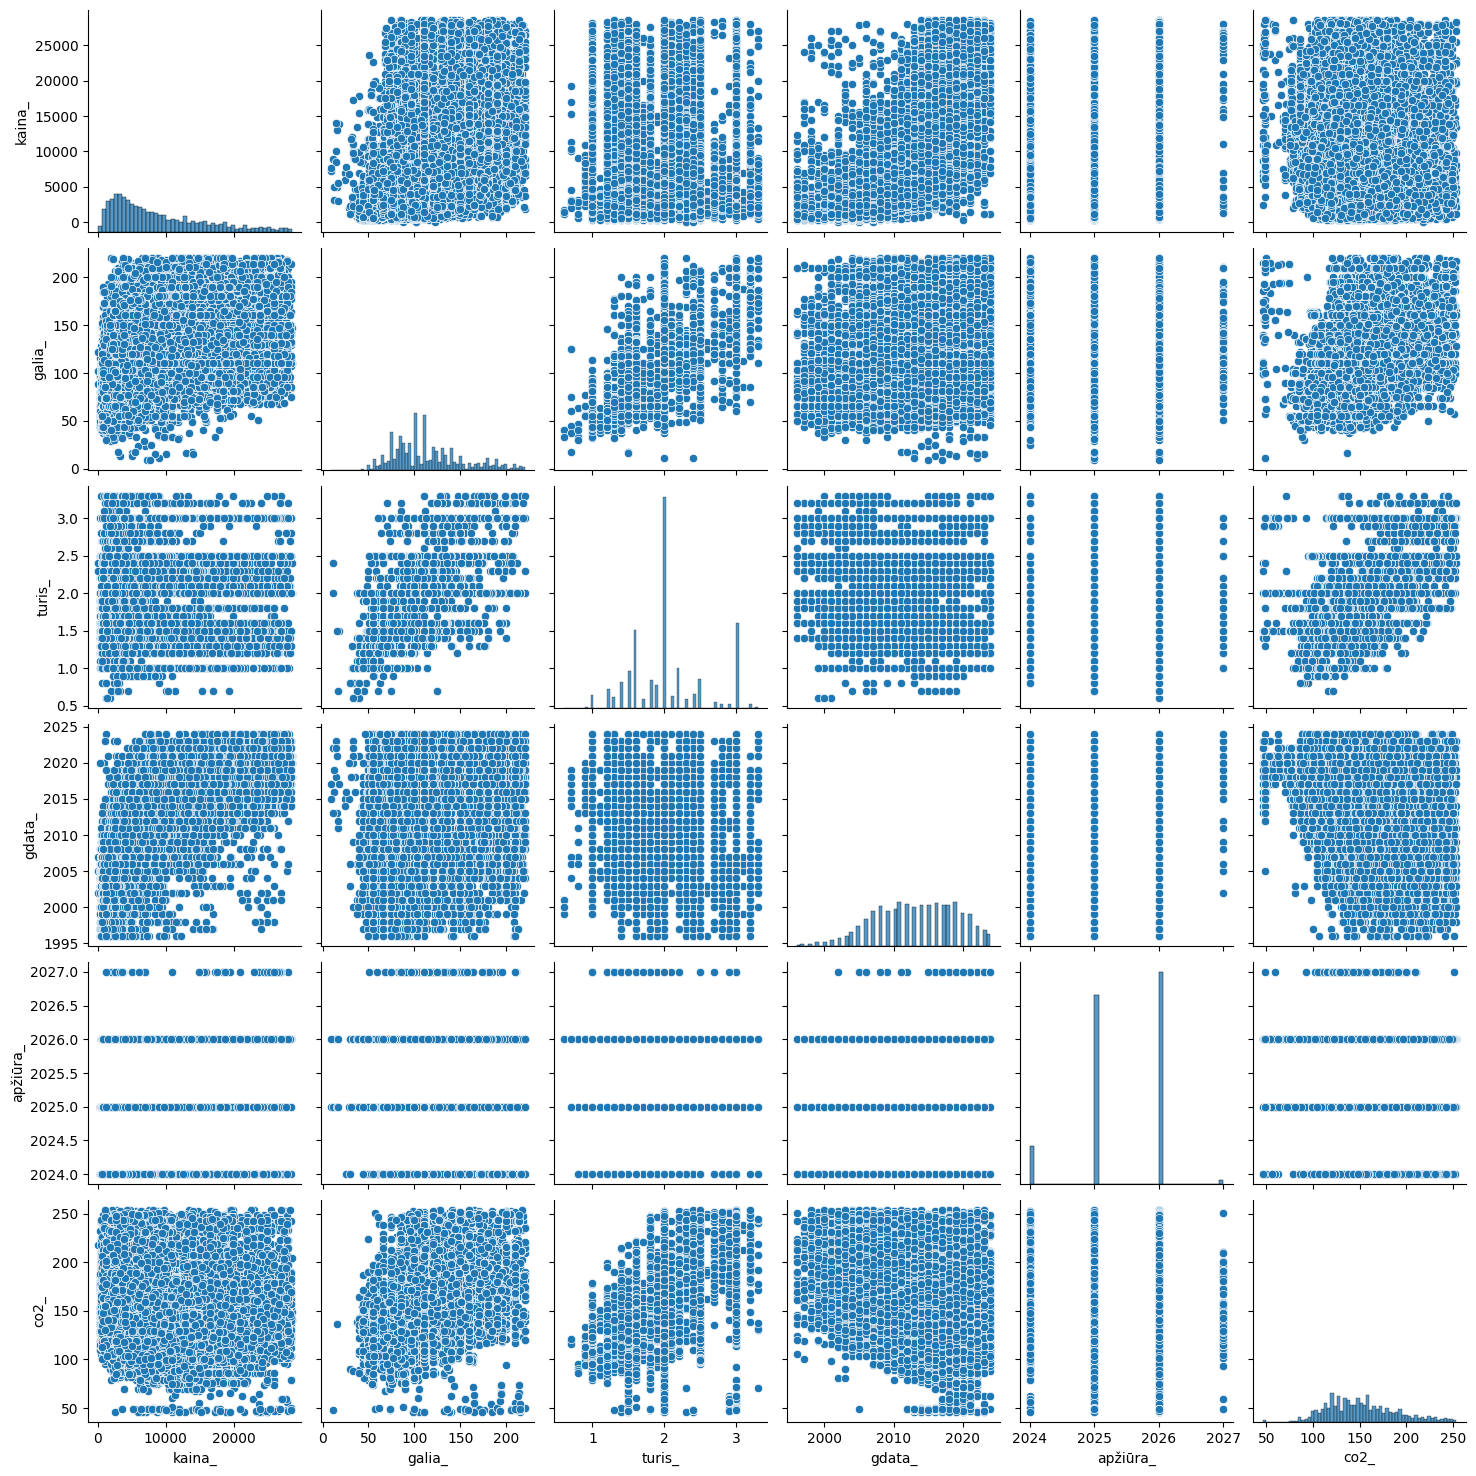

In [46]:
print("Generuojamas sns.pairplot(data=df1), EliteBook beveik 1 minutė.")
sns.pairplot(data=df1)

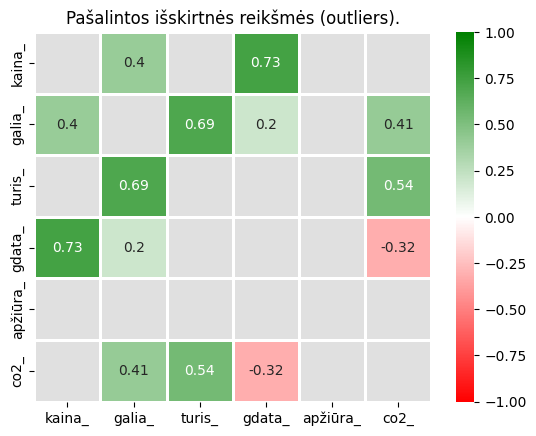

In [48]:
from matplotlib.colors import LinearSegmentedColormap

# Sukuriame pasirinktą spalvų schemą
colors = ["red", "white", "green"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
custom_cmap.set_bad(color="#E0E0E0")  # Pilka spalva `NaN` reikšmėms

cr_matrix = df1.corr(numeric_only=True,method='pearson')

# Nustatome modulio ribą
threshold = 0.2

# Panaikiname koreliacijas, kurių modulis mažesnis už ribą
cr_matrix = cr_matrix.where(abs(cr_matrix) >= threshold)

# Panaikiname įstrižainės reikšmes
np.fill_diagonal(cr_matrix.values, np.nan)

# Nubrėžiame heatmap su savo spalvų schema
sns.heatmap(data=cr_matrix,cmap=custom_cmap,annot=True,cbar=True,linecolor='white',linewidths='2',vmin=-1,vmax=1)

plt.title("Pašalintos išskirtnės reikšmės (outliers).")
plt.show()